In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # When True: it attempts to allocate only as much GPU memory as needed for the runtime allocations
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
train_set = pd.read_csv('Training_set.csv')
test_set = pd.read_csv('Testing_set.csv')

train_folder = 'train'
test_folder = 'test'

result_path = 'result'
# exist_ok: not to rise an error when directory already exists
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.h5")
loss_image_path = os.path.join(result_path, "validation_loss.png")
acc_image_path = os.path.join(result_path, "validation_accuracy.png")
confusion_image_path = os.path.join(result_path, "confusion_matrix.png")

In [5]:
train_set.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


<Axes: xlabel='label'>

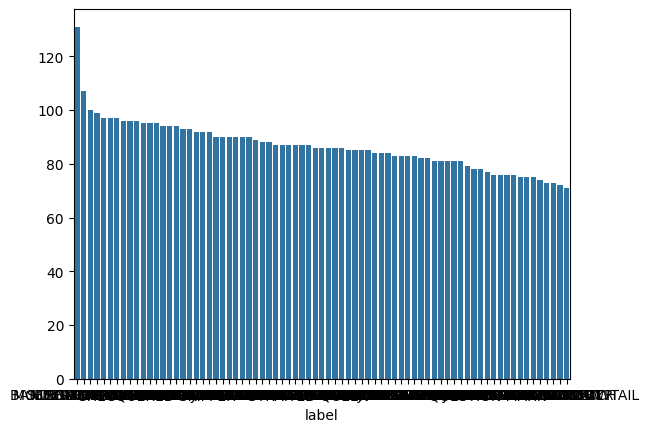

In [6]:
category_counts = train_set['label'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)

In [7]:
categories = train_set['label'].unique().tolist()
categories

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'EASTERN DAPPLE WHITE',
 'RED POSTMAN',
 'MANGROVE SKIPPER',
 'BLACK HAIRSTREAK',
 'CABBAGE WHITE',
 'RED ADMIRAL',
 'PAINTED LADY',
 'PAPER KITE',
 'SOOTYWING',
 'PINE WHITE',
 'PEACOCK',
 'CHECQUERED SKIPPER',
 'JULIA',
 'COMMON WOOD-NYMPH',
 'BLUE MORPHO',
 'CLOUDED SULPHUR',
 'STRAITED QUEEN',
 'ORANGE OAKLEAF',
 'PURPLISH COPPER',
 'ATALA',
 'IPHICLUS SISTER',
 'DANAID EGGFLY',
 'LARGE MARBLE',
 'PIPEVINE SWALLOW',
 'BLUE SPOTTED CROW',
 'RED CRACKER',
 'QUESTION MARK',
 'CRIMSON PATCH',
 'BANDED PEACOCK',
 'SCARCE SWALLOW',
 'COPPER TAIL',
 'GREAT JAY',
 'INDRA SWALLOW',
 'VICEROY',
 'MALACHITE',
 'APPOLLO',
 'TWO BARRED FLASHER',
 'MOURNING CLOAK',
 'TROPICAL LEAFWING',
 'POPINJAY',
 'ORANGE TIP',
 'GOLD BANDED',
 'BECKERS WHITE',
 'RED SPOTTED PURPLE',
 'MILBERTS TORTOISESHELL',
 'SILVER SPOT SKIPPER',
 'AMERICAN SNOOT',
 'AN 88',
 'ULYSES',
 'COMMON BANDED AWL',
 'C

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df = train_set.copy()
# add randomness to train dataframe, it actually gives better result(from 0.74 to 0.82)
df['split'] = np.random.randn(df.shape[0], 1)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# # We need to generate batches of tensor image data with real-time data augmentation as the GPU can't handle all dataset.
# # When we say “batches of tensor image data with real-time data augmentation”, it means we’re taking groups of images, 
# # applying some random transformations to them on-the-fly, and then feeding these transformed images to the model for training.
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    # if you have a dataset of 1000 examples, and you set batch_size=32, the model would take the first 32 examples 
    # and train on them, then it would take the next 32
    batch_size=32,
    seed=42,
    shuffle=True,
    # determine the type of label arrays that are returned. ‘sparse’ means a 1D integer label array is returned.
    class_mode="sparse",
    # this influance model accuracy, when I do 224, my gpu can't handle
    target_size=(150, 150))

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(150,150))

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="sparse",
    target_size=(150,150))

Found 4549 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.


In [12]:
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
base_model = ResNet50(
    # The weights='imagenet' argument is used to initialize the model with weights that were learned from training on the ImageNet dataset.
    weights='imagenet',
    # The include_top=False argument is used when we want to fine-tune the pre-trained model 
    # on a new task that has a different number of classes than the task the model was originally trained on.
    include_top=False,
    input_shape=(150, 150, 3)
)

In [14]:
# we want to fine-tune a pre-trained model, but only want to train a certain percentage of the layers.
# we need 80% of the layers to retrain.
# we use np.ceil in case if the model has less than 5 layers so the value can be always >= 1
# this one influence accuracy, if I will retrain not 80%, but for example 20%, the accuracy will decrease from 0.82 to 0.48!!!
num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))
for layer in base_model.layers[:num_layers_to_train]:
    # if false, the weights of these layers will not be updated
    layer.trainable = False

# This line is getting the output tensor of the base model. The output tensor of the base model is the last layer 
# of the ResNet50 model before the fully connected layers(Since include_top=False was specified, it is a convolutional layer).
x = base_model.output
# Adding a flatten layer, which converts the 2D feature maps to 1D feature vectors.
x = Flatten()(x)
# We add the fully connected layer, because combined with a non-linear activation function like ReLU (Rectified Linear Unit), 
# it introduces non-linearity into the model.
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
prediction = Dense(75, activation='softmax')(x)

# This line is creating a new model, using the input of the base model and the newly added layers as output.
model = Model(inputs=base_model.input, outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [15]:
import time

In [16]:
# compile the model for training
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Hitung waktu training
start_time = time.time()

# Latih model dengan menggunakan model checkpoint
history = model.fit(
    train_generator,
    epochs=100,
    validation_data = valid_generator,
    callbacks=[model_checkpoint, early_stopping]
)

# Hitung waktu training
end_time = time.time()

Epoch 1/100
143/143 [==============================] - 51s 295ms/step - loss: 7.3873 - accuracy: 0.3297 - val_loss: 8.6815 - val_accuracy: 0.0451
Epoch 2/100
143/143 [==============================] - 39s 275ms/step - loss: 4.2790 - accuracy: 0.7907 - val_loss: 6.5619 - val_accuracy: 0.2513
Epoch 3/100
143/143 [==============================] - 39s 273ms/step - loss: 2.9523 - accuracy: 0.9508 - val_loss: 4.1340 - val_accuracy: 0.6092
Epoch 4/100
143/143 [==============================] - 40s 276ms/step - loss: 2.2738 - accuracy: 0.9914 - val_loss: 3.2833 - val_accuracy: 0.7138
Epoch 5/100
143/143 [==============================] - 40s 279ms/step - loss: 1.8155 - accuracy: 0.9989 - val_loss: 2.7650 - val_accuracy: 0.7415
Epoch 6/100
143/143 [==============================] - 40s 277ms/step - loss: 1.4759 - accuracy: 0.9974 - val_loss: 2.5060 - val_accuracy: 0.7313
Epoch 7/100
143/143 [==============================] - 40s 281ms/step - loss: 1.2543 - accuracy: 0.9862 - val_loss: 2.3568 -

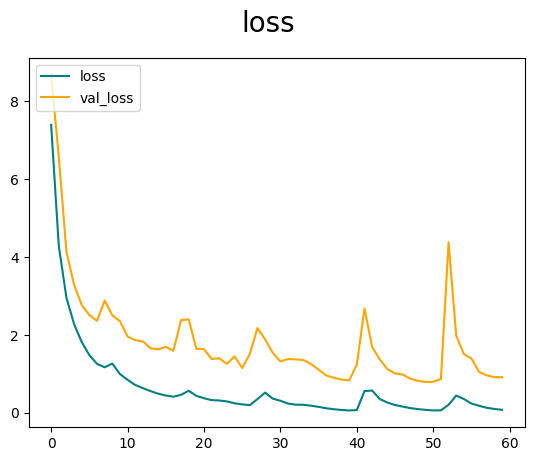

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

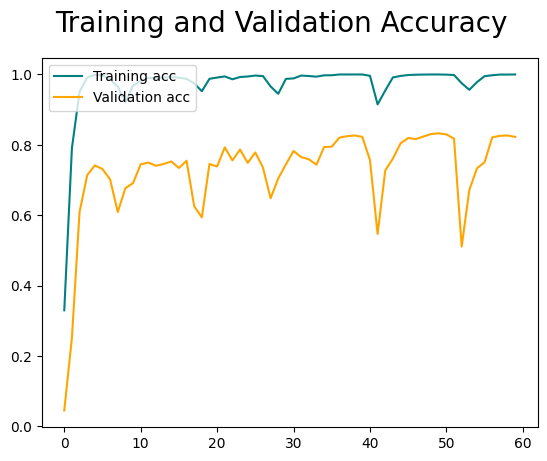

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='Training acc')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation acc')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [19]:
from sklearn.metrics import classification_report

# predict
yhat = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Assuming yhat are probabilities and you're interested in the class with the highest probability
yhat_classes = np.argmax(yhat, axis=-1)

# Now yhat_classes should have the same shape as y_val
y_test = test_generator.classes

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Generate a classification report
classification_rep = classification_report(y_test, yhat_classes, target_names=class_labels, digits=4)
print("Classification Report:\n", classification_rep)

# Save the classification report to a file
classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)


31/31 [==============================] - 4s 92ms/step
Classification Report:
                            precision    recall  f1-score   support

                   ADONIS     0.8235    0.9333    0.8750        15
AFRICAN GIANT SWALLOWTAIL     1.0000    1.0000    1.0000        10
           AMERICAN SNOOT     0.7000    0.6364    0.6667        11
                    AN 88     1.0000    1.0000    1.0000        11
                  APPOLLO     0.9375    1.0000    0.9677        15
                    ATALA     0.9167    0.9167    0.9167        12
 BANDED ORANGE HELICONIAN     0.9231    0.9231    0.9231        13
           BANDED PEACOCK     0.6667    0.6667    0.6667         9
            BECKERS WHITE     0.9167    0.7333    0.8148        15
         BLACK HAIRSTREAK     0.8889    0.8421    0.8649        19
              BLUE MORPHO     1.0000    0.8889    0.9412         9
        BLUE SPOTTED CROW     0.7059    0.8571    0.7742        14
           BROWN SIPROETA     0.9524    0.8333    